In [37]:
from util import *
df = load_bout()
df['level'] = [1 if val > 150 else 0 for val in df['step']]
users = getSortedUser(df)
n_user = len(users)
bout_ratio = getBoutRatio(df)

In [78]:
color['all'] = 'tab:olive'
def plot_scale_hour(name, df_, scale_type = 'nbout'):
    # display(pd.concat([getBoutRatio(df_.query(f"uid == @name and level == @level"), normalize = False) for level in range(2)],keys=["low_level","high_level"]))
    fig, axes = plt.subplots(nrows = 4, ncols = 2, figsize = (24, 7.2), sharex = True, sharey= 'col')
    for idx, btype in enumerate(["phone","watch","both", "all"]):
        for ldx, level in enumerate(["Low","High"]):
            data = df_.query(f"uid == @name and level == @ldx")
            if btype!= "all":
                data = data.query(f"btype == '{btype[0]}'")
            data = data.groupby(["hour"]).agg(nbout = ("step", "count"), step = ("step","sum"))
            data = data.reindex(np.arange(24), fill_value = 0)
            axes[idx][ldx].bar(x = np.arange(0,24), height = data[scale_type].to_numpy(), color = color[btype])           
            
            axes[idx][ldx].set_xlabel(f"{btype} bout, {level} level, {scale_type}")
            axes[idx][ldx].set_xticks(np.arange(0,24,3))
            axes[idx][ldx].set_xticklabels([str(jdx*3).zfill(2) for jdx in range(8)])                                    
    plt.tight_layout()
    plt.show()

b    0.880787
p    0.087160
w    0.032053
Name: 75, dtype: float64

23

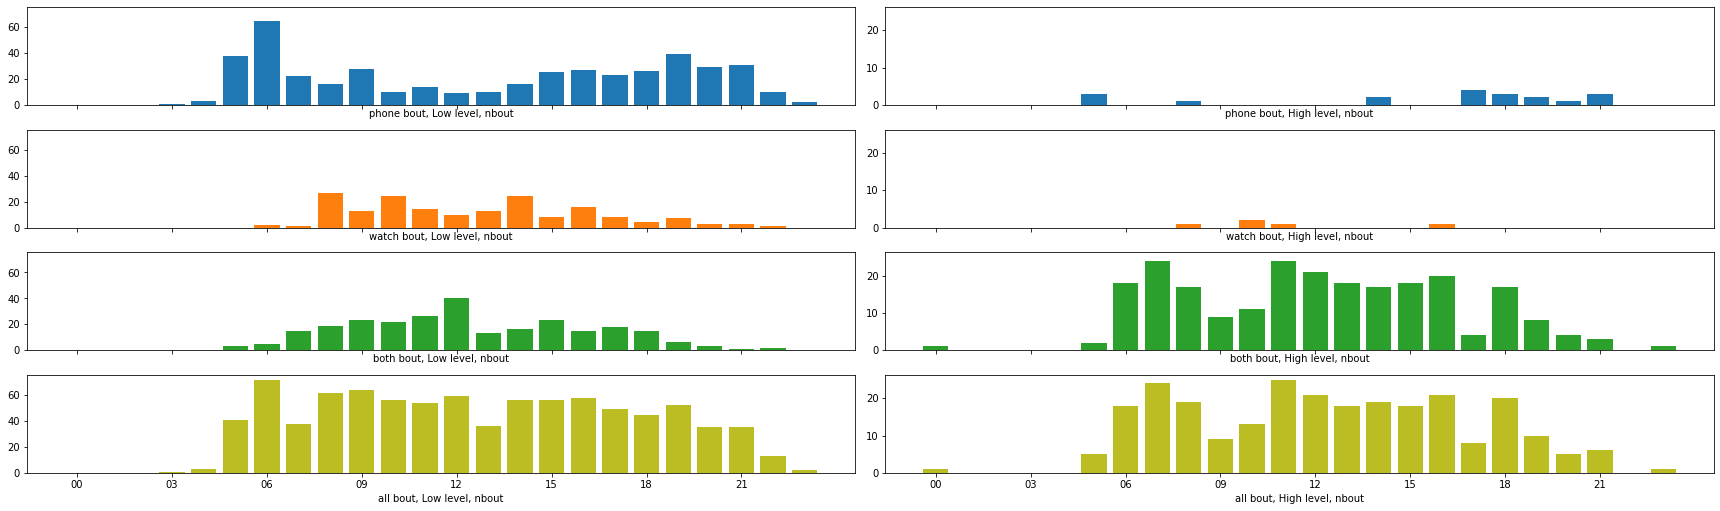

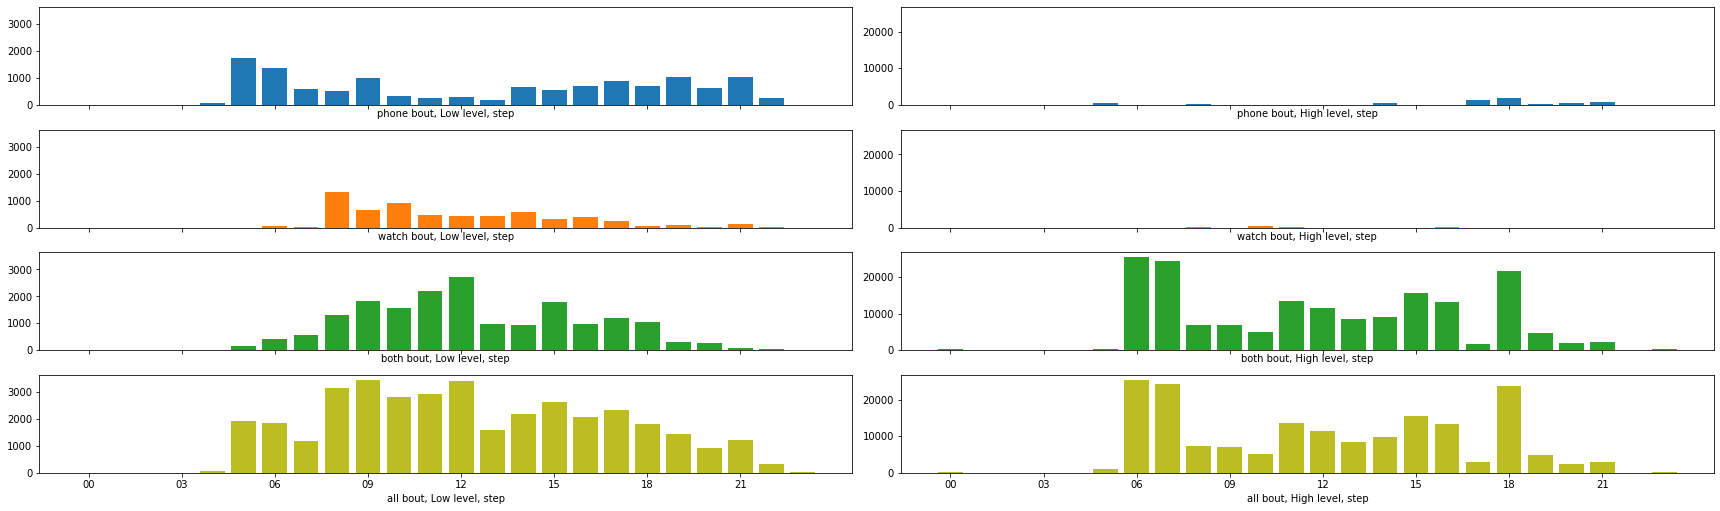

In [79]:
# wanted = 37 #근무 중에는 폰만, 그리고 출퇴근에는 워치만
df_ = df.query("weekday < 5") 
bout_ratio = getBoutRatio(df_)
# wanted = 80 #그냥 선택적으로 들고 다니는 듯???
# wanted = 44 #거의 항상 들고다니넹
# wanted = 3  # Phone step 4,6시에 진짜 규칙적으로 안들고 다님. Watch 안 끼고 어디 가나?
# wanted = 1 #밤에 운동할때만 찬다.
# wanted = 44 #그냥 폰을 거의 사용하지 않음
# wanted = 18 #그냥 Watch Preference가 강한듯???
wanted = 75
display(bout_ratio.loc[wanted])
display(len(set(df_.query("uid == @wanted")['date'])))
for stype in ['nbout', 'step']:
    plot_scale_hour(wanted, df_, stype)

In [99]:
color['all'] = 'tab:olive'
def plot_scale_hour_noagg(name, df_):
    udf = df_.query(f"uid == @name")
    ndate = len(set(udf['date']))
    for date in sorted(set(udf['date'])):
        fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (24, 4.8), sharex = True, sharey= 'row')
        for ldx, level in enumerate(["Low","High"]):
            for idx, stype in enumerate(["nbout","step"]):
                bottom = np.zeros(24)
                for bdx, btype in enumerate(["both","phone","watch"]):
                    data = udf.query(f"level == @ldx and date == @date")
                    if btype!= "all":
                        data = data.query(f"btype == '{btype[0]}'")
                    data = data.groupby(["hour"]).agg(nbout = ("step", "count"), step = ("step","sum"))
                    data = data.reindex(np.arange(24), fill_value = 0)
                    axes[idx][ldx].bar(x = np.arange(0,24), height = data[stype].to_numpy(), color = color[btype])
                    bottom += data[stype].to_numpy()

                axes[idx][ldx].set_xlabel(f"{date} of {level} level, {stype}")
                axes[idx][ldx].set_xticks(np.arange(0,24,3))
                axes[idx][ldx].set_xticklabels([str(jdx*3).zfill(2) for jdx in range(8)])                                    
        plt.tight_layout()
        plt.show()
        plt.close()

b    0.616040
p    0.370132
w    0.013828
Name: 6, dtype: float64

29

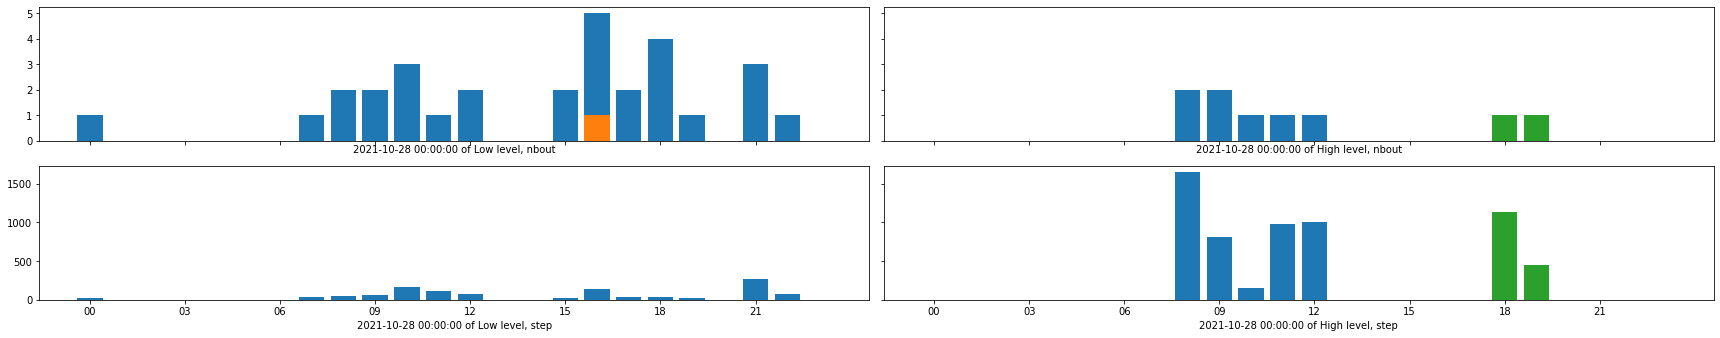

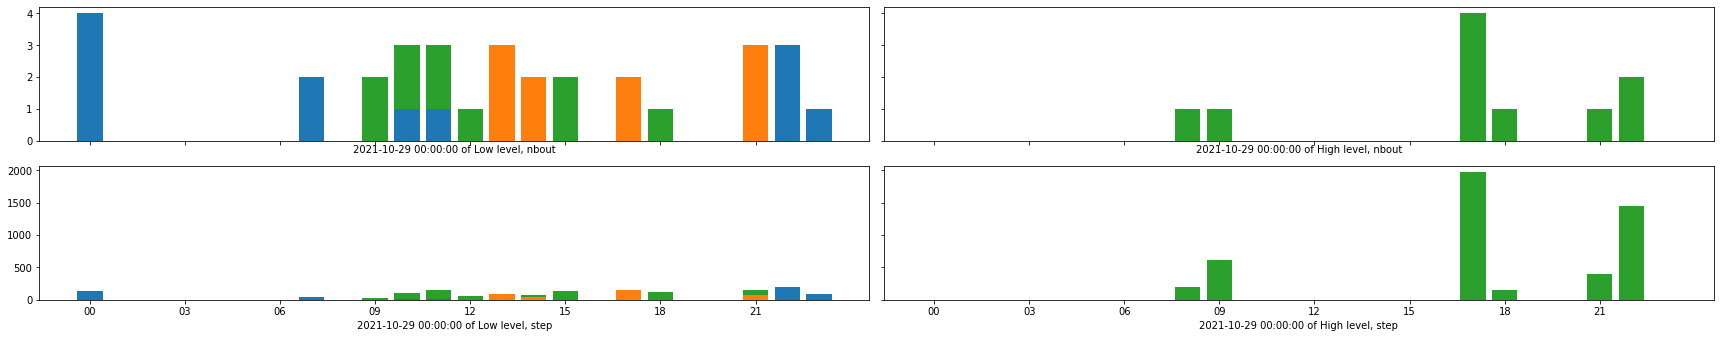

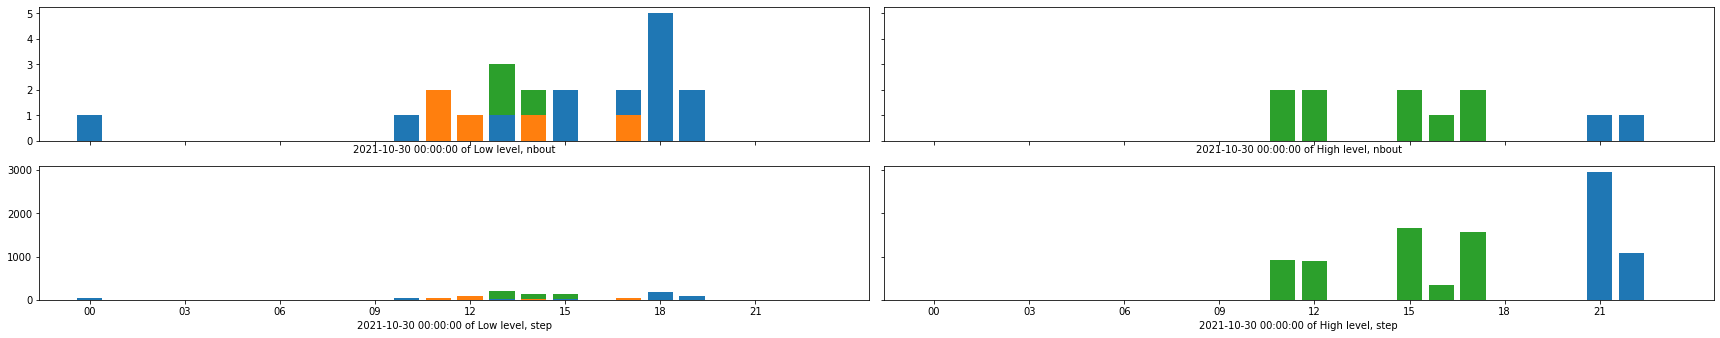

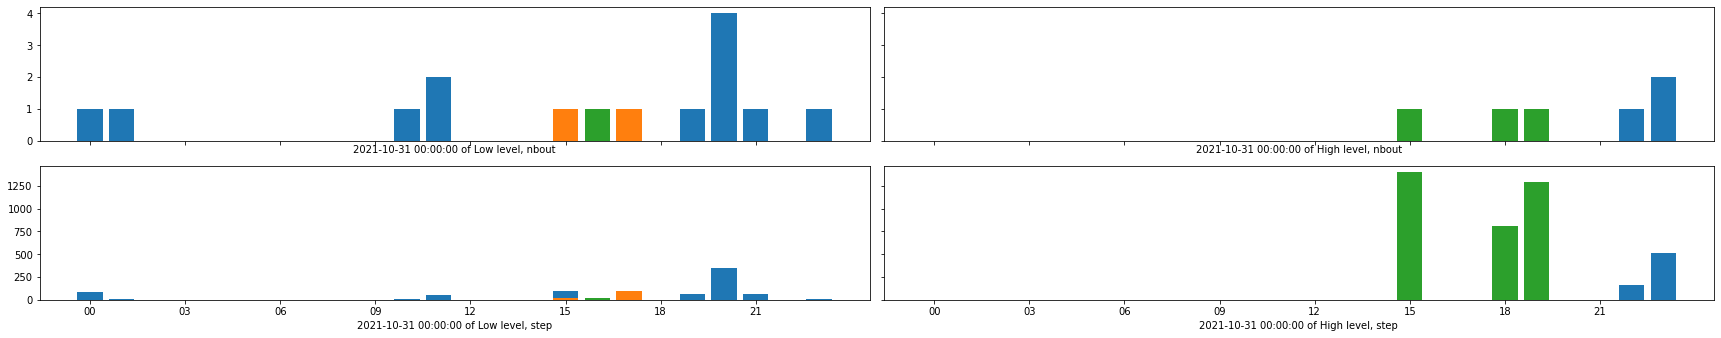

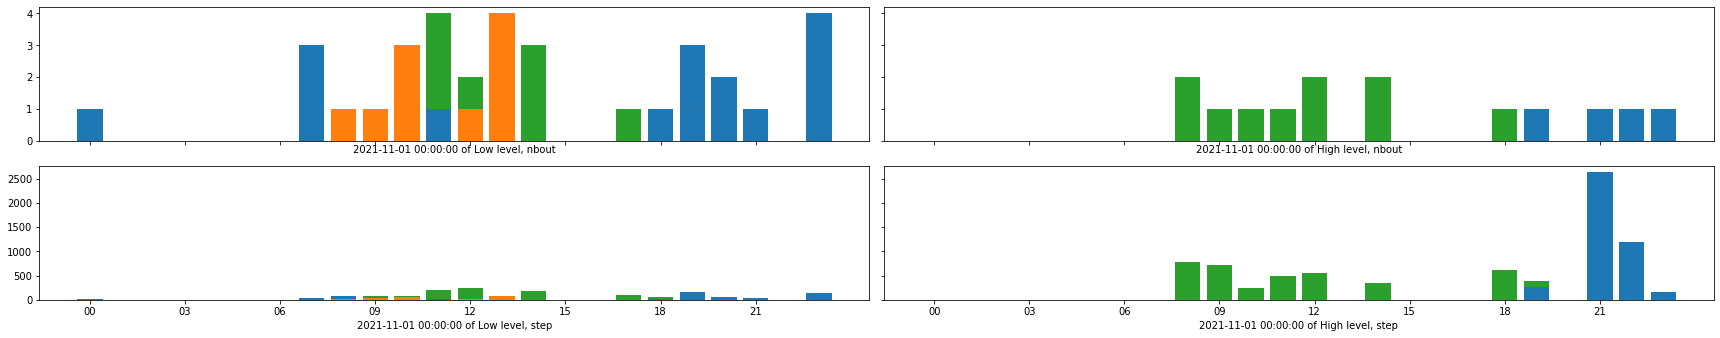

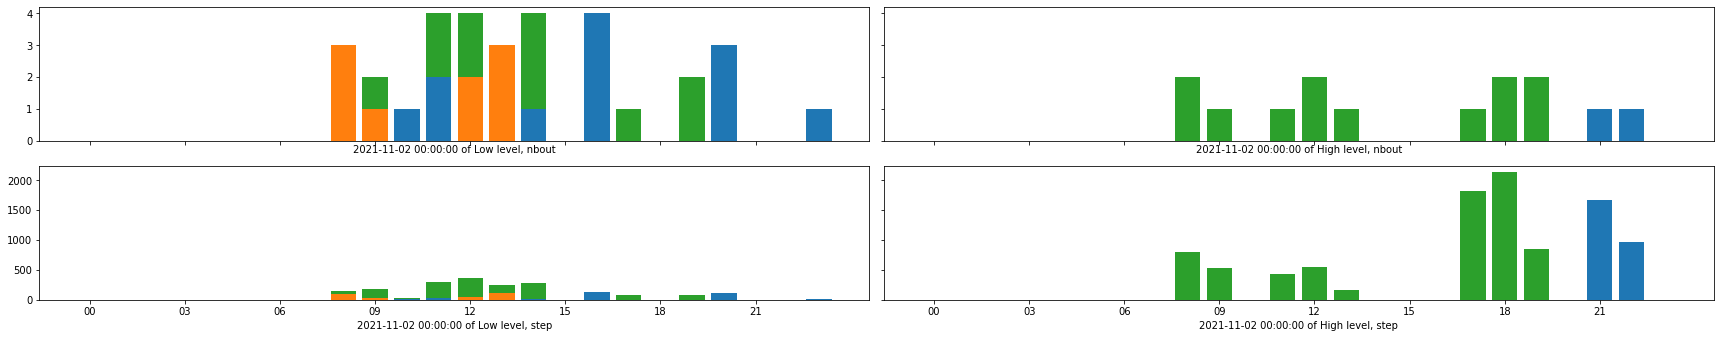

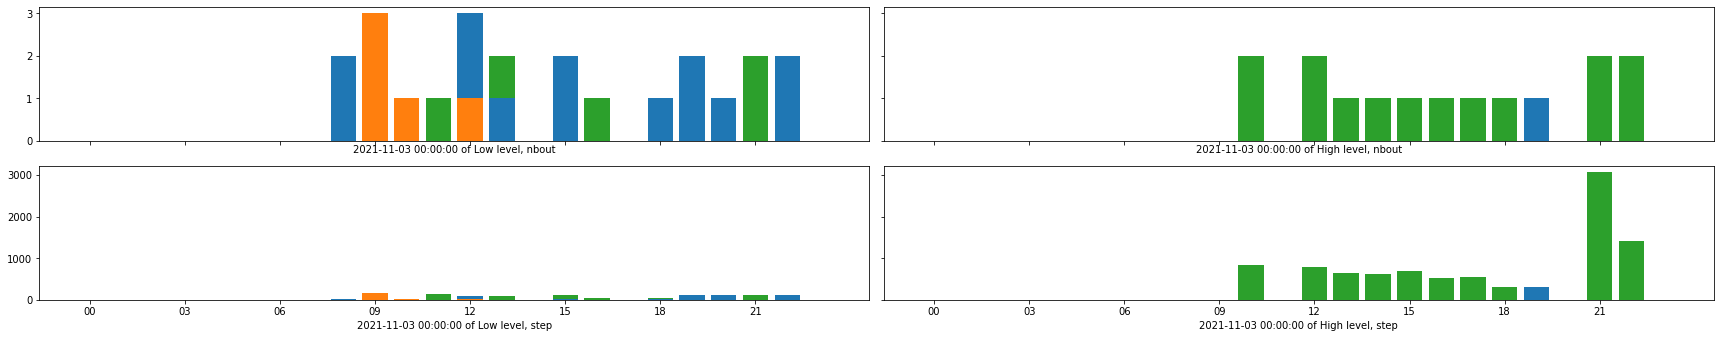

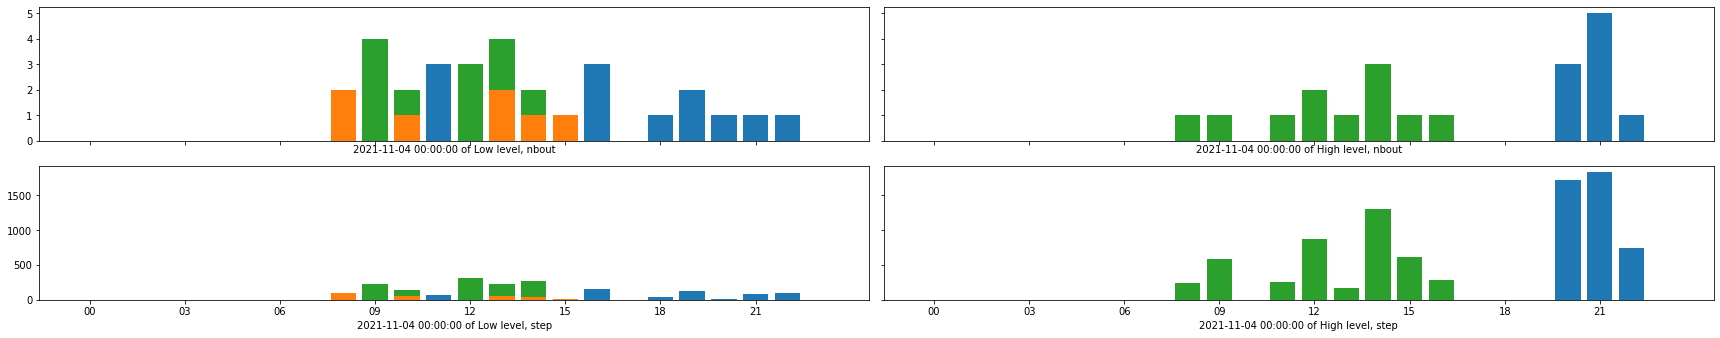

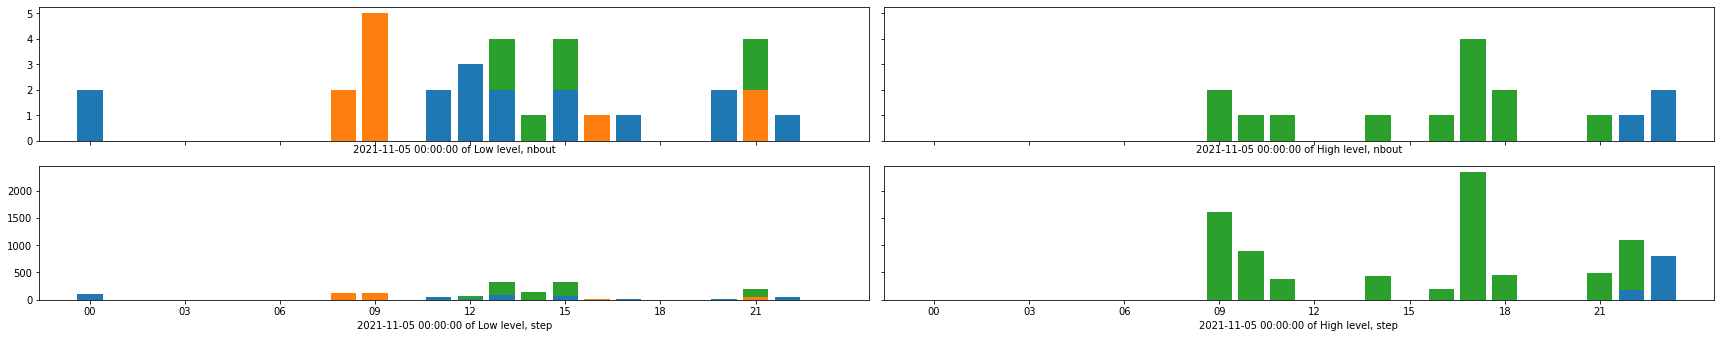

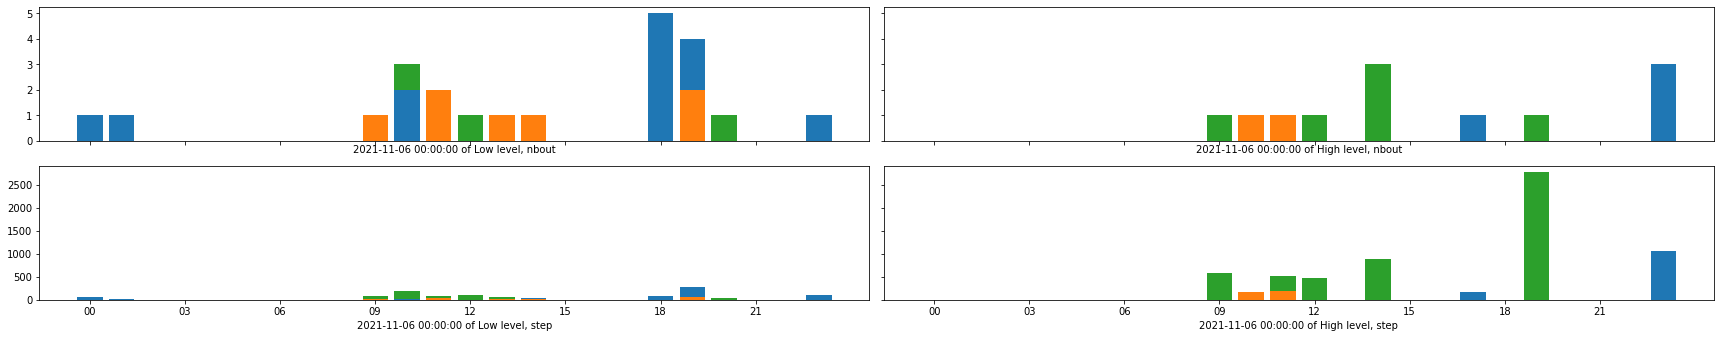

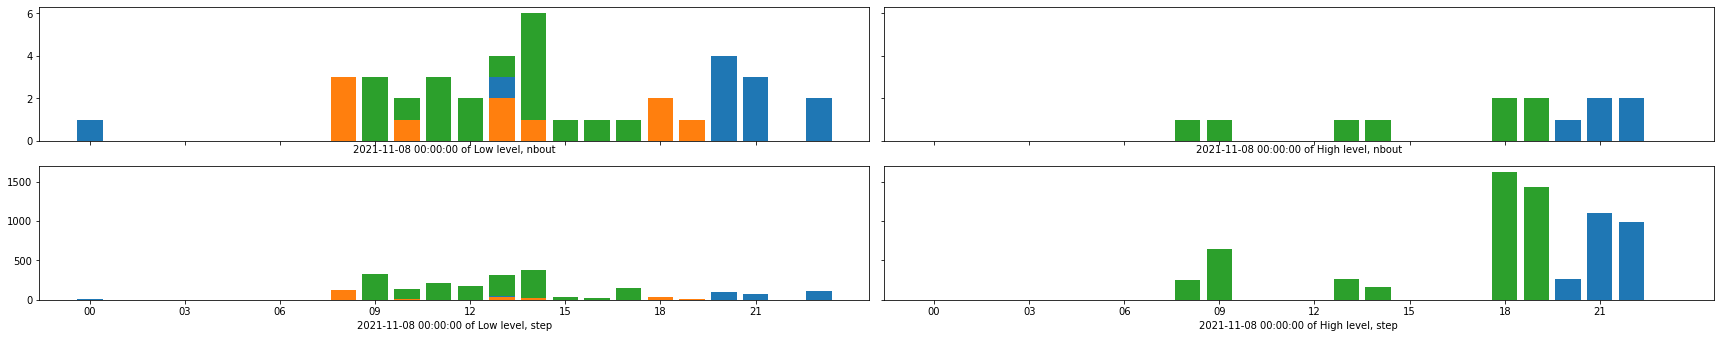

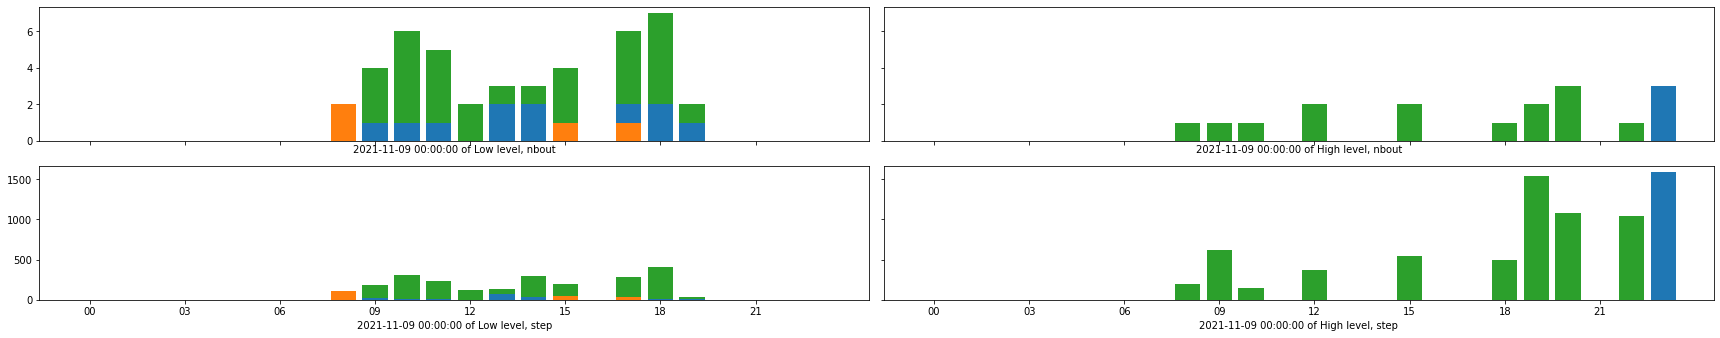

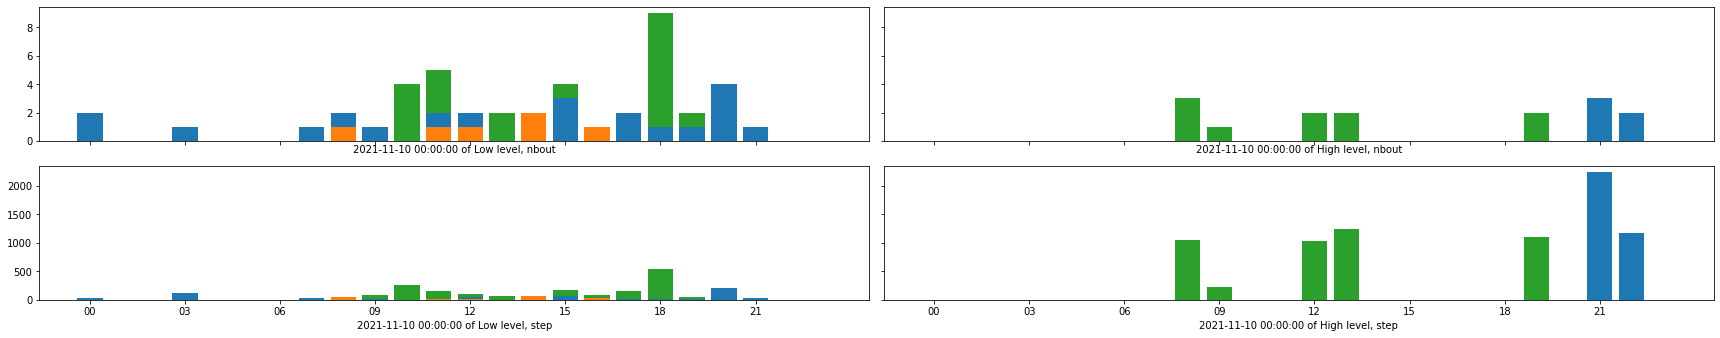

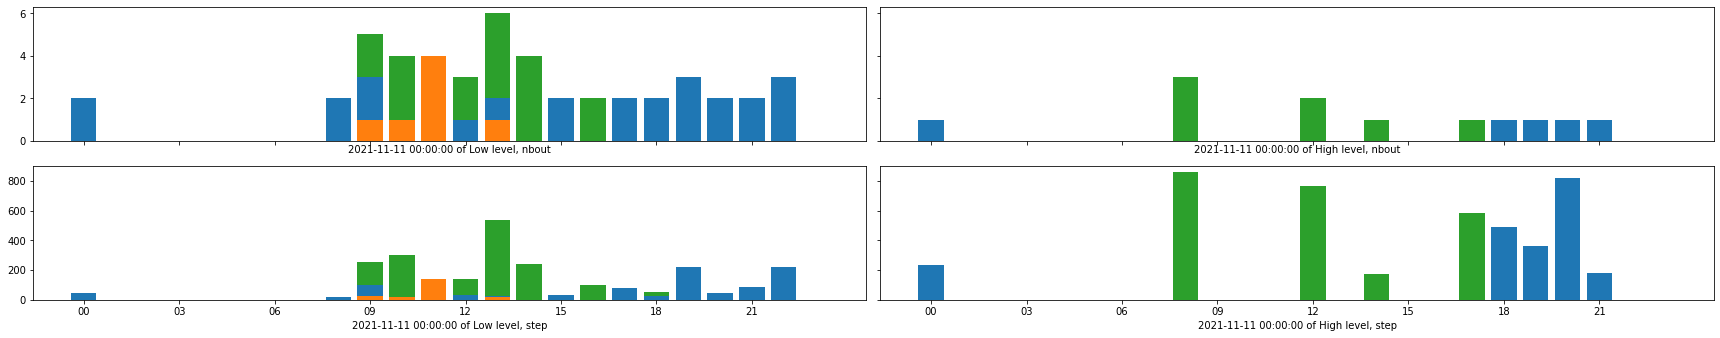

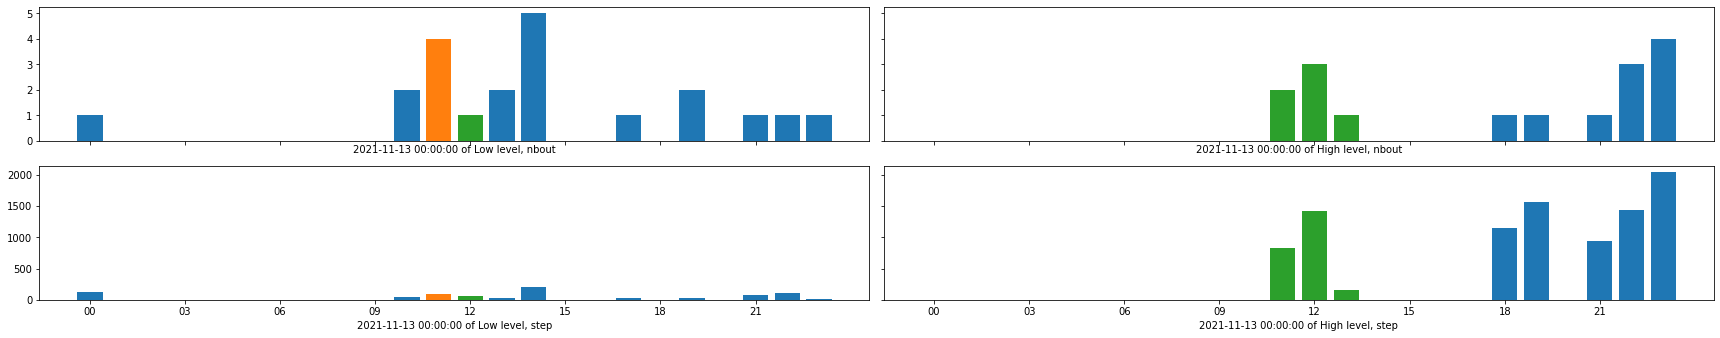

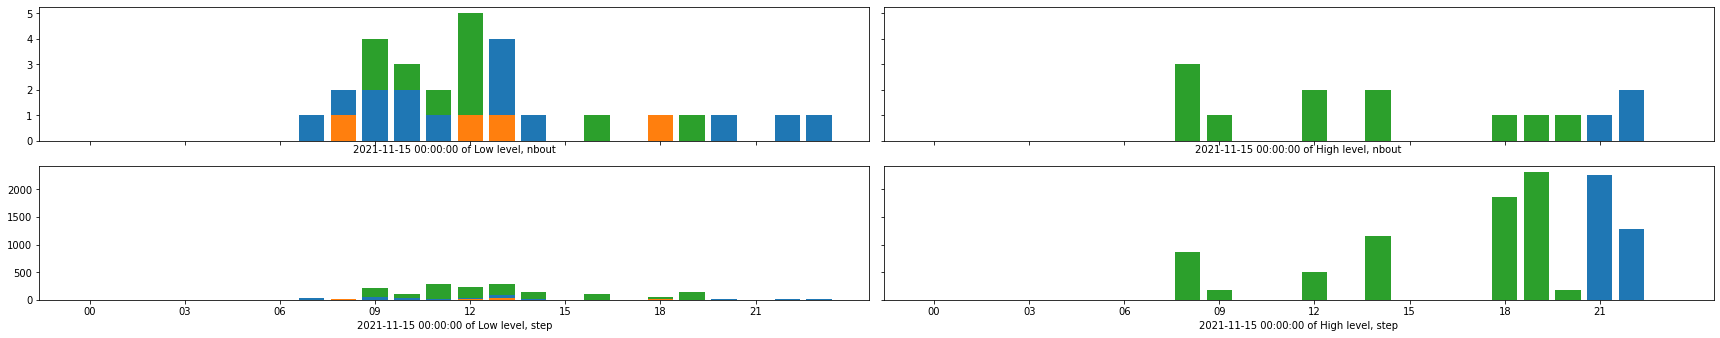

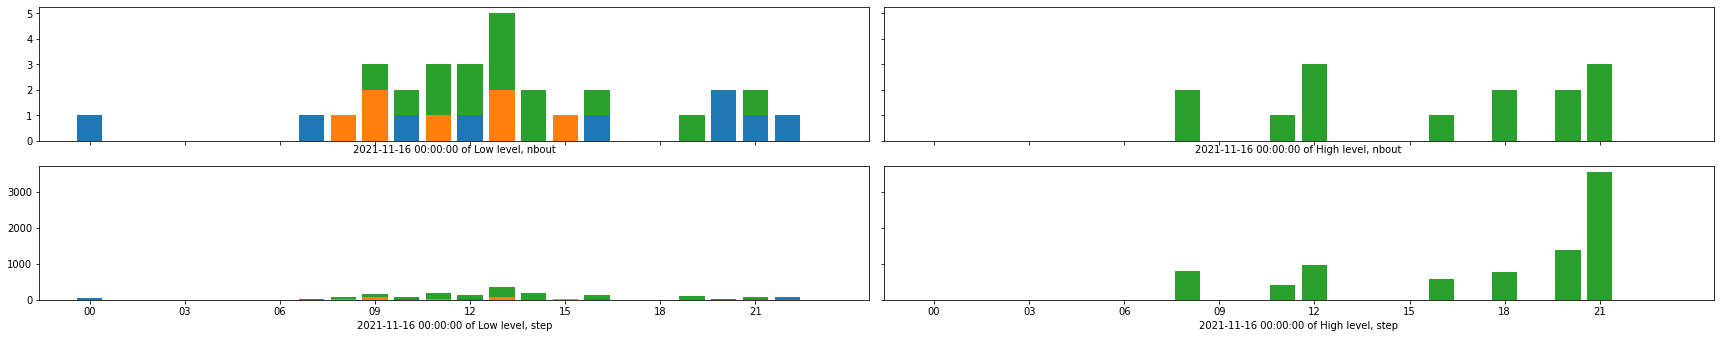

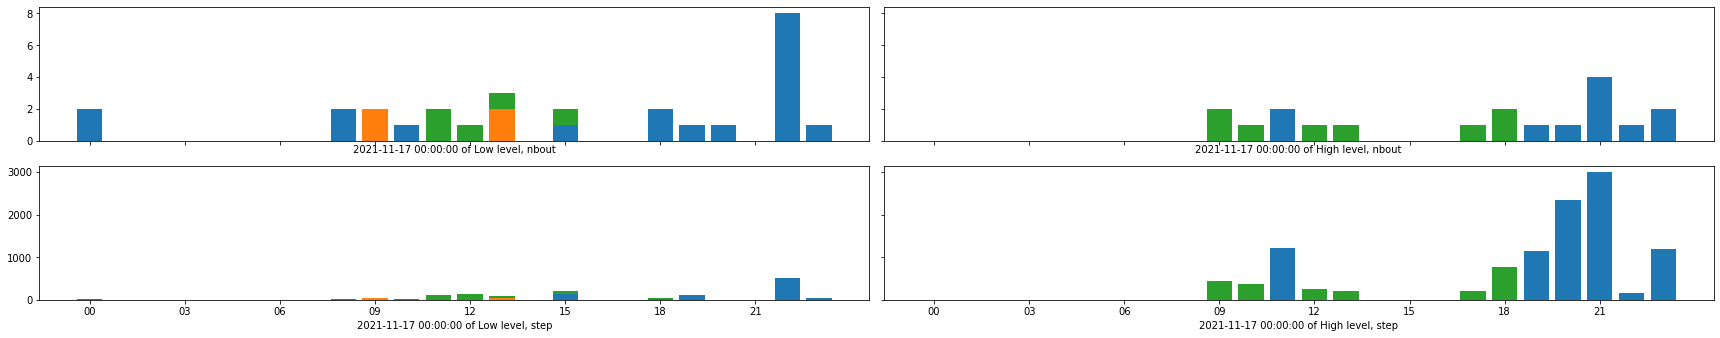

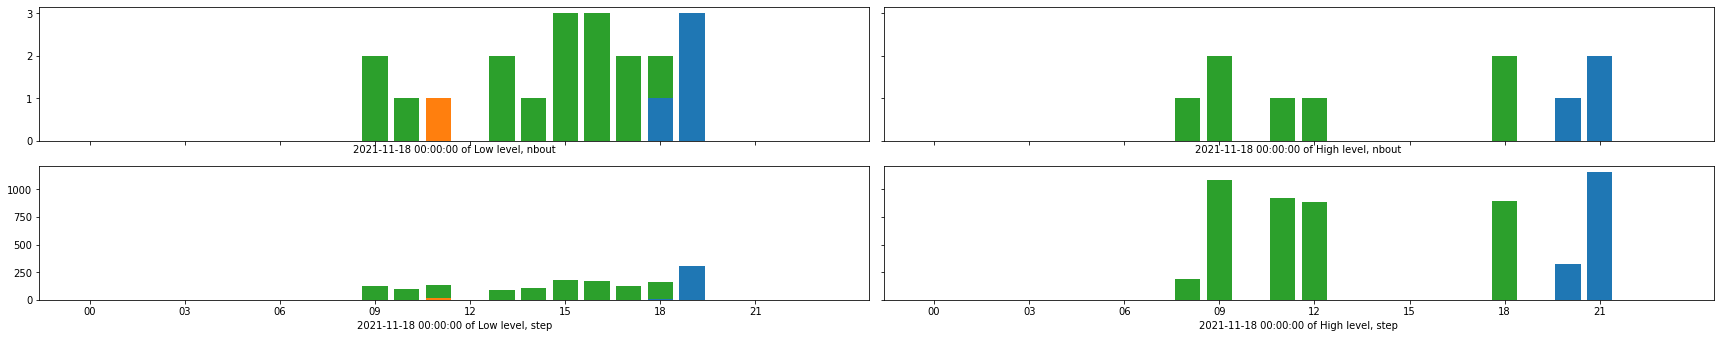

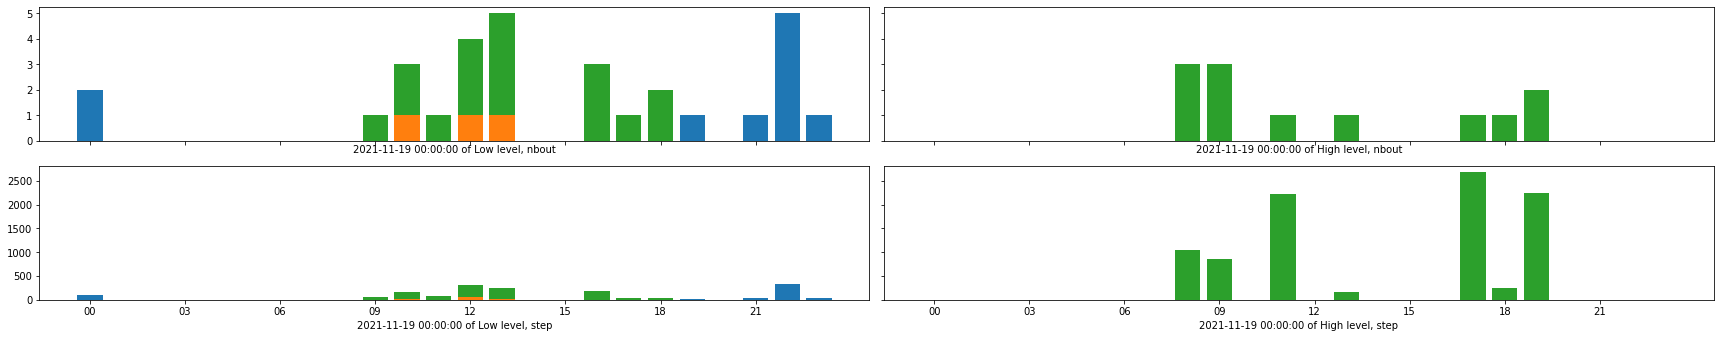

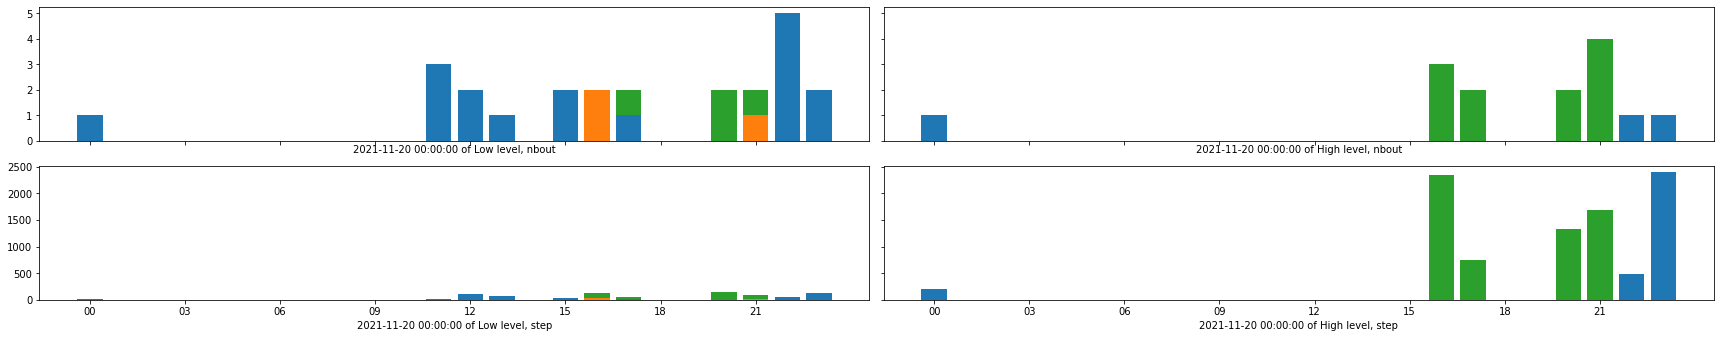

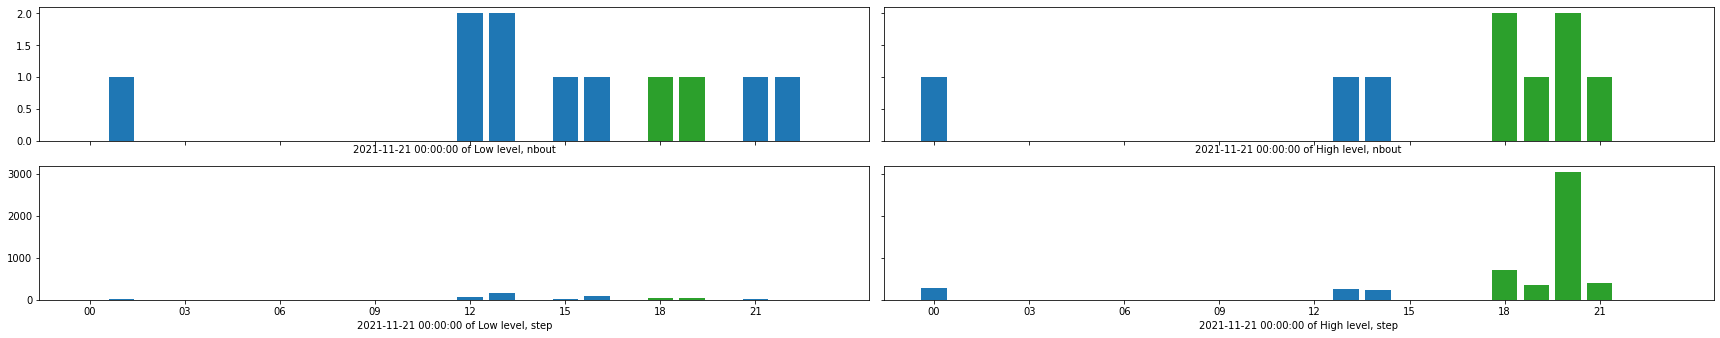

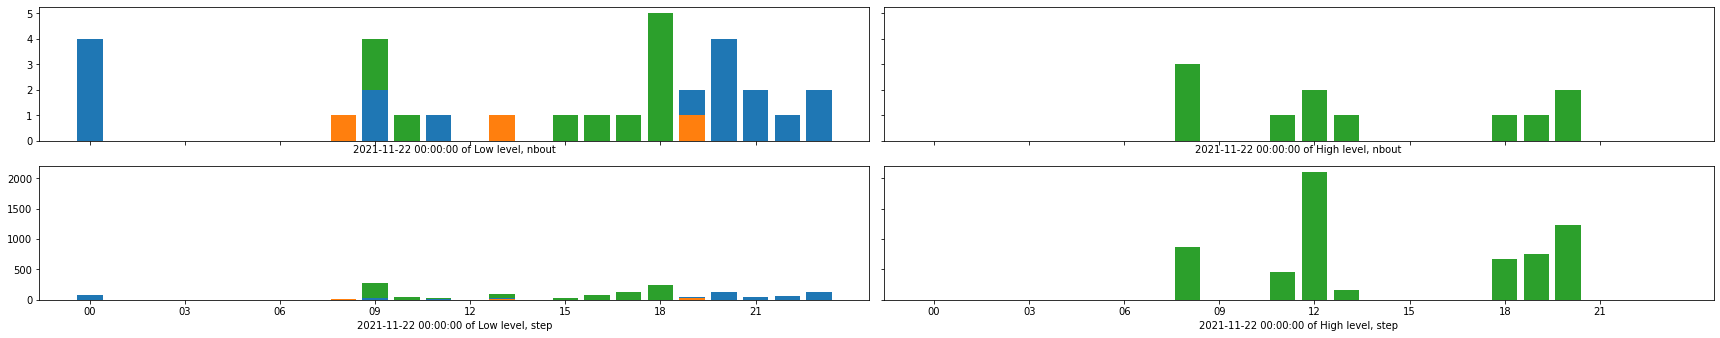

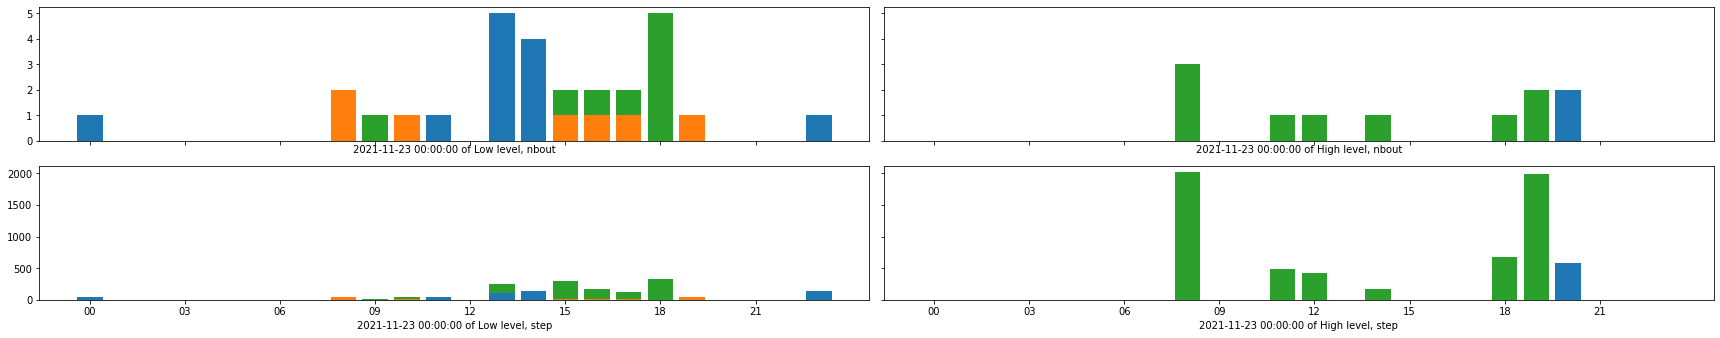

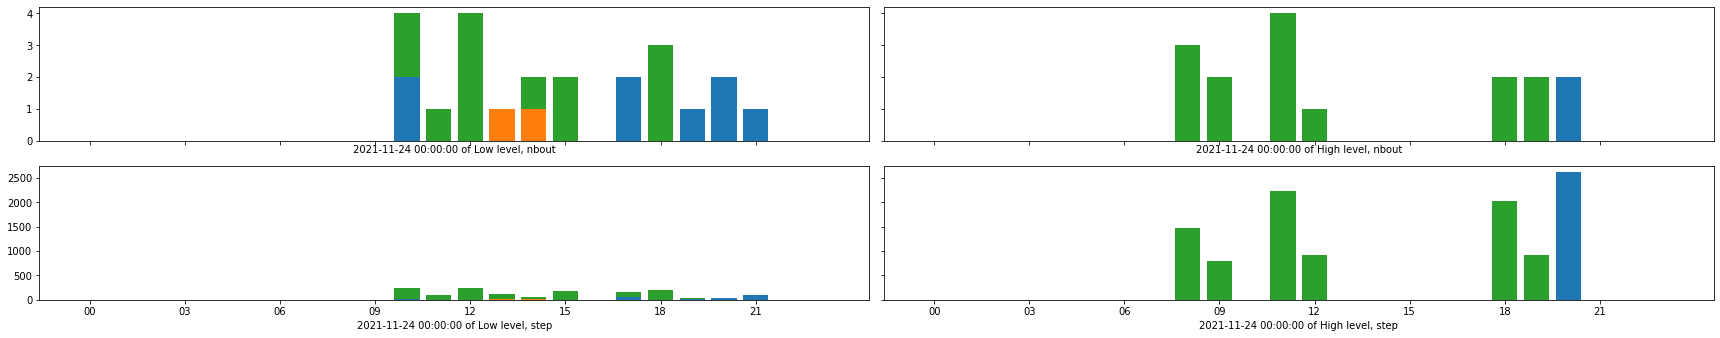

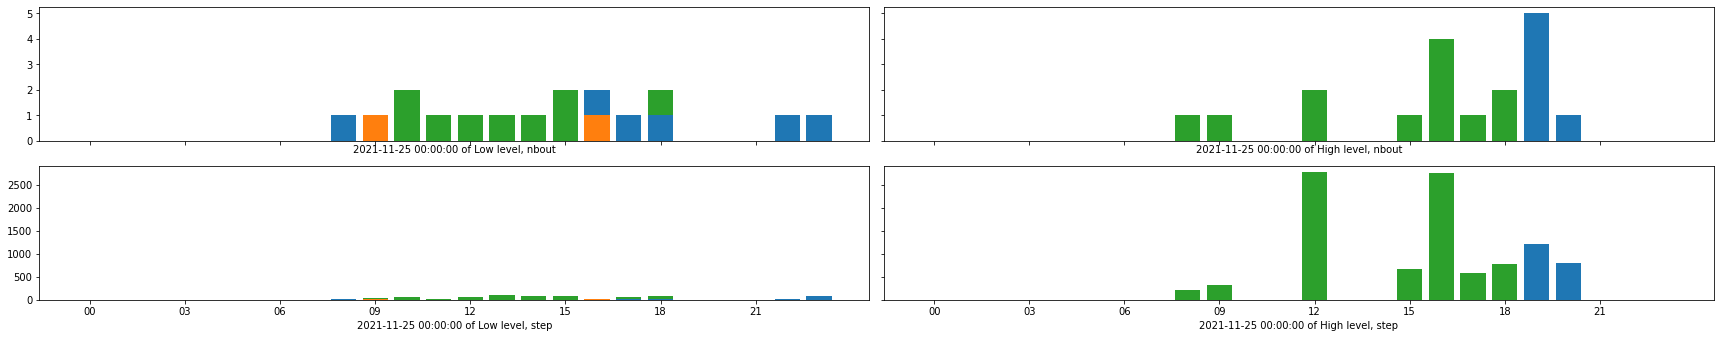

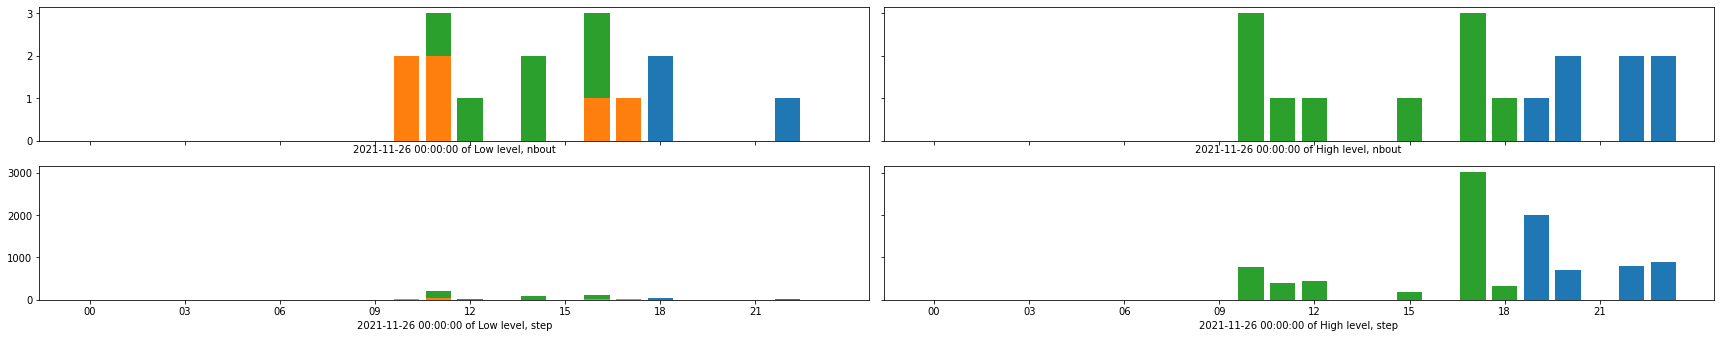

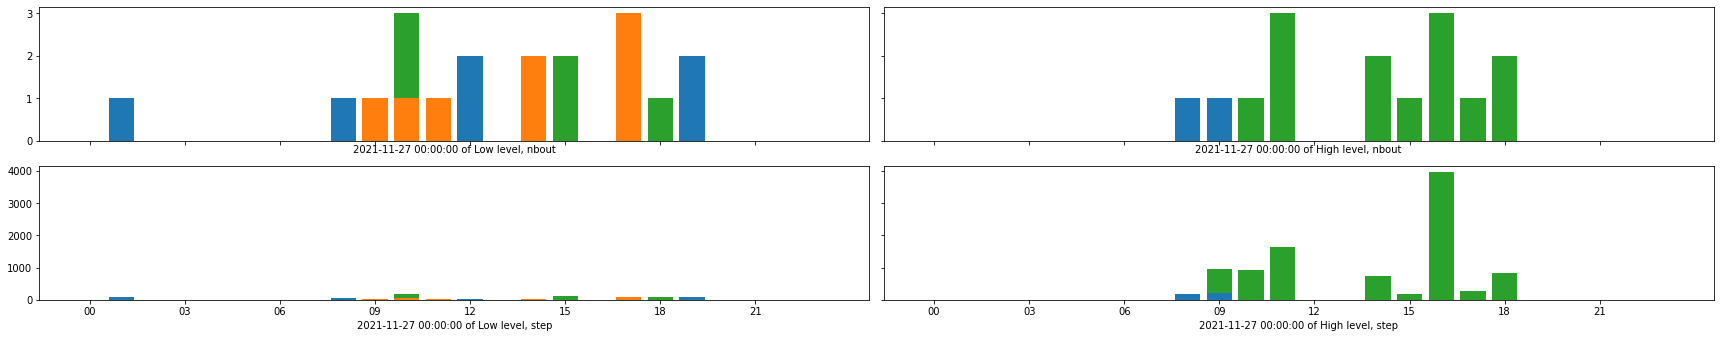

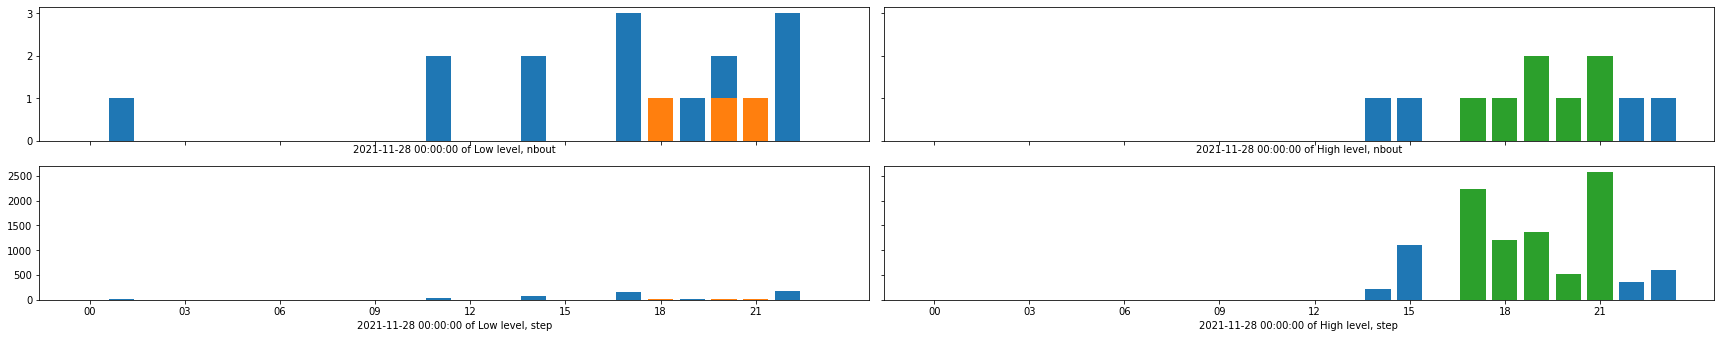

In [105]:
# wanted = 37 #운동 마니아로 판명
wanted = 6
display(bout_ratio.loc[wanted])
display(len(set(df_.query("uid == @wanted")['date'])))
plot_scale_hour_noagg(wanted, df_)

In [101]:
def show_user_bout_ratio(df_, save_name):
    btypes = ["both", "phone", "watch"]
    nrows, ncols = 1, 1
    fig, ax = plt.subplots(nrows = nrows, ncols = ncols, figsize =(6.4*2.5*ncols, 4.8 * nrows))
    for i in range(2):
        data = getBoutRatio(df_.query("level == @i"), normalize = False).sort_index(level =0, key= lambda x: [users.index(user) for user in x.to_numpy()])
        bottom = np.zeros(n_user)
        for btype in btypes:
            ax.bar(x = np.arange(n_user)*2.5+.5 + i, height = data[btype[0]].to_numpy(), bottom = bottom, label = btype, color = color[btype])
            bottom += data[btype[0]].to_numpy()
    ax.set_xticks(np.arange(n_user)*2.5+1)
    ax.set_xticklabels(users,  rotation= 90)
    ax.set_xlabel(save_name)
    ax.set_ylim([0,600000])
    plt.tight_layout()
    plt.savefig(f"{save_name}.png",facecolor = 'white', transparent = False)
    plt.show()

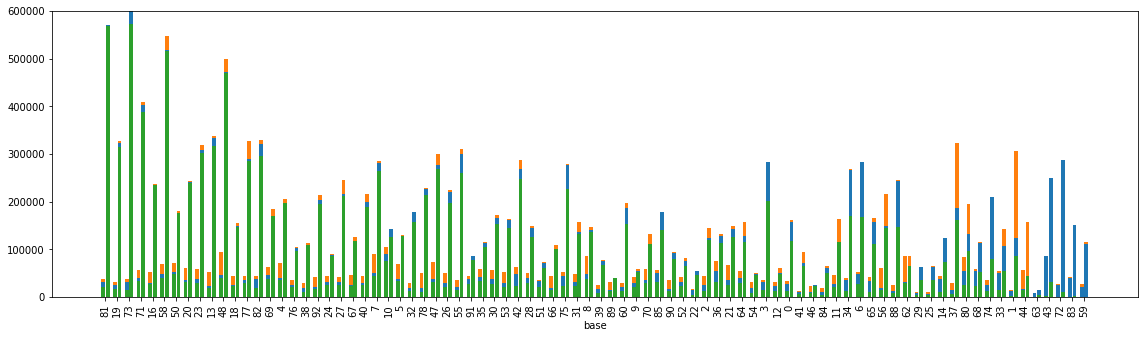

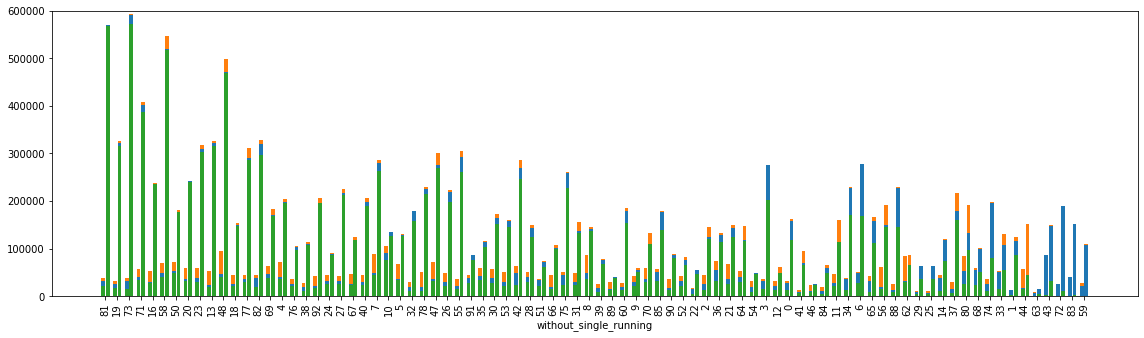

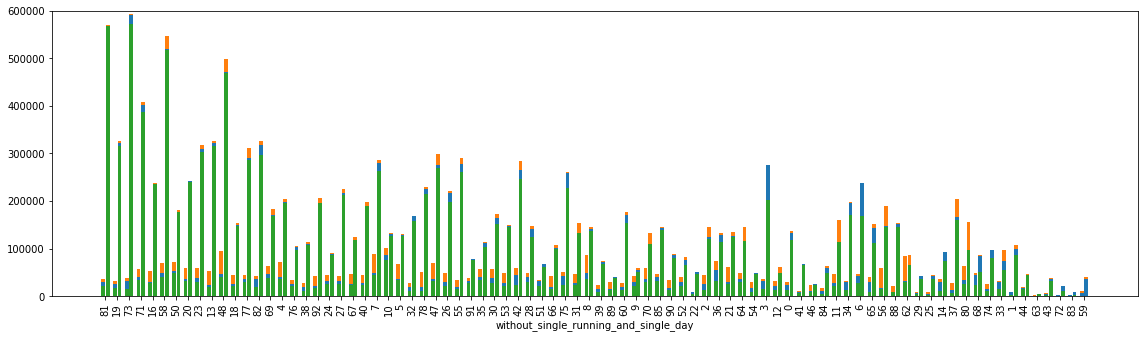

In [104]:
show_user_bout_ratio(df, "base")
statement = "(step < 3000 or btype=='b')"
show_user_bout_ratio(df.query(statement), "without_single_running")

tmp = df.query(statement).groupby(["uid", "date","btype"]).agg(step = ("step","sum"))
tmp = tmp.unstack(level=2, fill_value = 0)
tmp.columns = ['b','p','w']
# tmp_sum = np.sum(tmp.to_numpy(),axis = 1)
tmp = tmp.apply(lambda x: x/np.sum(x),axis = 1)
tmp = tmp.query("p < 0.95 and w < 0.95")
df_ = df.query(statement).set_index(["uid","date"])
df_ = df_[df_.index.isin(tmp.index)]
df_ =df_.reset_index()
# statement += " and (wearing_ratio < 0.95 and carrying_ratio < 0.95)"
show_user_bout_ratio(df_, "without_single_running_and_single_day")

# df_ = df_.query("weekday < 5")
# show_user_bout_ratio(df_, "without_single_running_and_single_day_and_weekend")